# Collaborative Filtering Recommendation System on Vellore Positions of Interest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./data/location_ratings.csv")

In [3]:
df.head()

,Timestamp,Vellore Fort,Golden Temple,Karigiri,Hot Stone,Limra,Tara Maa,Saleem's,Wraps and Fries,Frozen bottle,Lalit Vihar,The Chocolate Room,7th Heaven,Food Boutique,McDonalds,Chick-In,Galaxy Cinemas,PVR Cinemas,INOX Cinemas,Sri Vishnu Cinemas
0,2023-09-13 05:43:50,5,5,5,5,3,5,4,0,2,5,5,2,3,3,5,5,2,3,3
1,2023-09-07 11:27:27,2,0,3,3,5,3,4,5,1,5,2,2,1,5,3,2,5,5,5
2,2023-09-15 08:32:39,5,1,2,5,5,1,5,2,1,1,5,4,3,5,4,3,5,5,4
3,2023-11-03 07:00:24,3,3,5,3,5,2,3,3,4,3,5,3,5,5,5,5,4,2,5
4,2023-09-18 11:44:34,3,3,5,2,4,4,2,5,4,1,5,5,5,5,3,3,5,5,3


In [4]:
# remove the first column as it is unnecessary, we would like to replace it with a UserID
df = df.iloc[:,1:]
df.insert(0, 'UserID', range(1, 1 + len(df)))

In [5]:
df.shape

(82, 20)

We have responses from 82 people on 19 POI's (Points Of Interest).

In [6]:
df.isnull().sum()

UserID                0
Vellore Fort          0
Golden Temple         0
Karigiri              0
Hot Stone             0
Limra                 0
Tara Maa              0
Saleem's              0
Wraps and Fries       0
Frozen bottle         0
Lalit Vihar           0
The Chocolate Room    0
7th Heaven            0
Food Boutique         0
McDonalds             0
Chick-In              0
Galaxy Cinemas        0
PVR Cinemas           0
INOX Cinemas          0
Sri Vishnu Cinemas    0
dtype: int64

There are no null values in any entry. <Br>

In [7]:
df.head()

,UserID,Vellore Fort,Golden Temple,Karigiri,Hot Stone,Limra,Tara Maa,Saleem's,Wraps and Fries,Frozen bottle,Lalit Vihar,The Chocolate Room,7th Heaven,Food Boutique,McDonalds,Chick-In,Galaxy Cinemas,PVR Cinemas,INOX Cinemas,Sri Vishnu Cinemas
0,1,5,5,5,5,3,5,4,0,2,5,5,2,3,3,5,5,2,3,3
1,2,2,0,3,3,5,3,4,5,1,5,2,2,1,5,3,2,5,5,5
2,3,5,1,2,5,5,1,5,2,1,1,5,4,3,5,4,3,5,5,4
3,4,3,3,5,3,5,2,3,3,4,3,5,3,5,5,5,5,4,2,5
4,5,3,3,5,2,4,4,2,5,4,1,5,5,5,5,3,3,5,5,3


<Axes: >

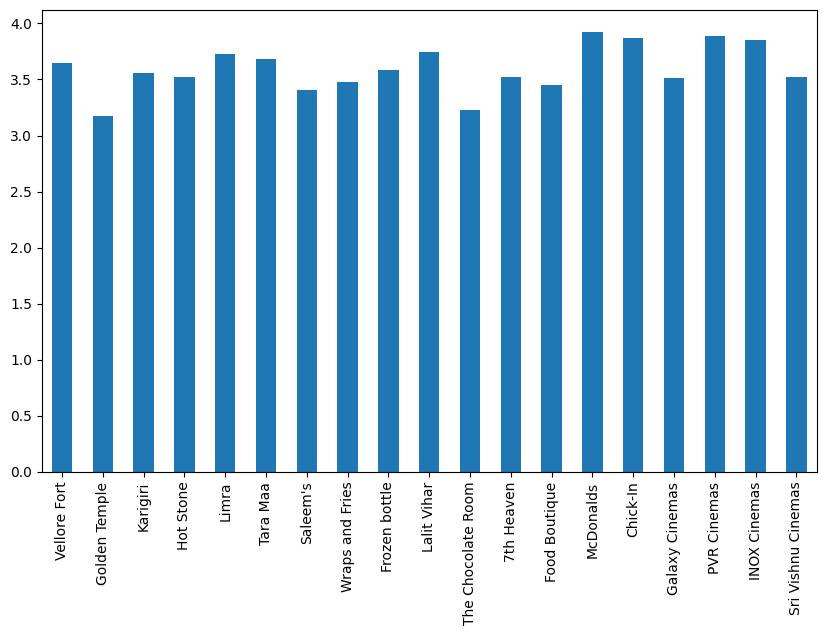

In [8]:
# plotting the average rating of each location
df.iloc[:, 1:].mean().plot(kind='bar', figsize=(10, 6))

<Axes: >

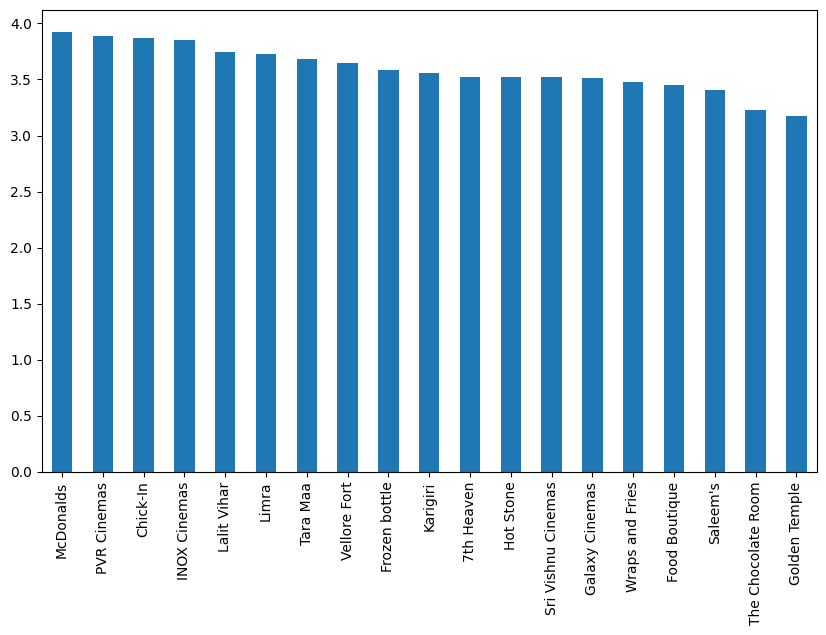

In [9]:
# plotting the average rating of each location sorted by average rating
df.iloc[:, 1:].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))

<Axes: >

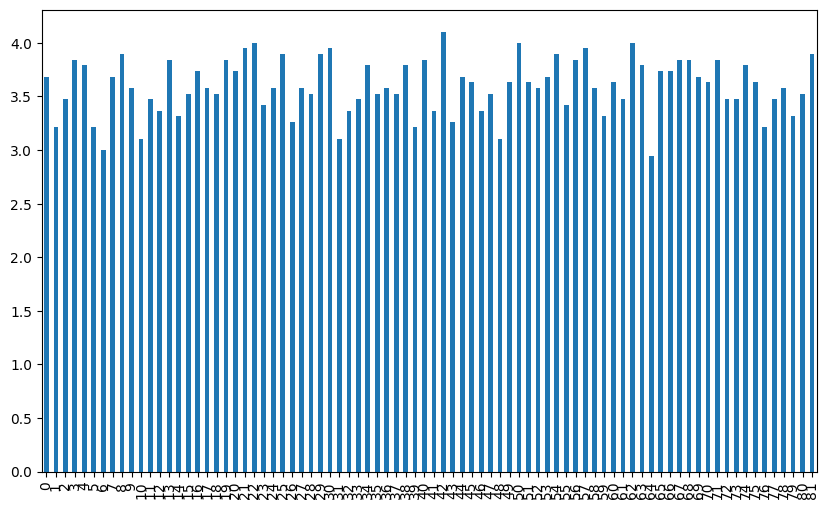

In [10]:
# plotting the average rating given by each user
df.iloc[:, 1:].mean(axis=1).plot(kind='bar', figsize=(10, 6))

## Inferences

We can see that most places have an average rating in the range of 3 - 5. <br>
The location with the highest average rating is : McDonalds<Br>
The location with lowest average rating is : Golden Temple<br>

# FastAI Collaborative Model

In [11]:
from fastai.tabular.all import *
from fastai.collab import *
import torch

In [12]:
# Melt the dataframe to have UserID, Location_Name, and Rating to match fastai import data structure
melted_data = pd.melt(df, id_vars=['UserID'], var_name='Location_Name', value_name='Rating')

# Display the first few rows of the melted dataframe
melted_data.head()

,UserID,Location_Name,Rating
0,1,Vellore Fort,5
1,2,Vellore Fort,2
2,3,Vellore Fort,5
3,4,Vellore Fort,3
4,5,Vellore Fort,3


In [13]:
# creating the DataLoader object
dls = CollabDataLoaders.from_df(melted_data, bs=10)

In [14]:
dls.show_batch()

,UserID,Location_Name,Rating
0,24,Limra,5
1,13,Saleem's,1
2,32,The Chocolate Room,4
3,68,INOX Cinemas,4
4,6,Chick-In,2
5,42,Karigiri,2
6,45,INOX Cinemas,5
7,33,The Chocolate Room,5
8,42,7th Heaven,3
9,23,Frozen bottle,5


In [15]:
# Creating latent factors

n_users  = len(dls.classes['UserID'])
n_locations = len(dls.classes['Location_Name'])

# We assume that there are 5 latent factors that affect a user's enjoyment of a location
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_locations, n_factors)

In [16]:
# This is the Dot product model to predict the user's liking of a location

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range= (0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        # Accounting for the biases from a user. i.e: some users just rate everything higher than others.
        self.user_bias = Embedding(n_users, 1)
        
        self.location_factors = Embedding(n_movies, n_factors)
        # Accounting for the biases in a POI. i.e: some locations simply have people rate them higher or lower than other similar locations.
        self.location_bias = Embedding(n_locations, 1)

        # range of ratings is from 0-5 but we still use 5.5 as it has been found to provide better results
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        locations = self.location_factors(x[:,1])
        res = (users * locations).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.location_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [17]:
x,y = dls.one_batch()
print(x)
print(x.shape)

tensor([[11,  5],
        [ 2,  6],
        [76, 15],
        [62, 15],
        [14, 13],
        [16, 18],
        [61, 13],
        [39, 11],
        [55,  7],
        [28,  1]])
torch.Size([10, 2])


In [20]:
model = DotProduct(n_users, n_locations, 20)

# Using the MeanSquaredError loss function
learn = Learner(dls, model, loss_func=MSELossFlat())

# Training with weight decay = 0.1, lr at 5e-3
# We are using the one_cycle_callback
learn.fit_one_cycle(10, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,2.534355,2.618787,00:01
1,2.269215,2.128779,00:01
2,1.904614,1.907678,00:01
3,1.632773,1.975496,00:01
4,1.383685,2.049852,00:01
5,1.258344,2.119697,00:01
6,1.087119,2.164467,00:01
7,0.994020,2.199743,00:01
8,0.988380,2.207599,00:01
9,0.873404,2.208973,00:01


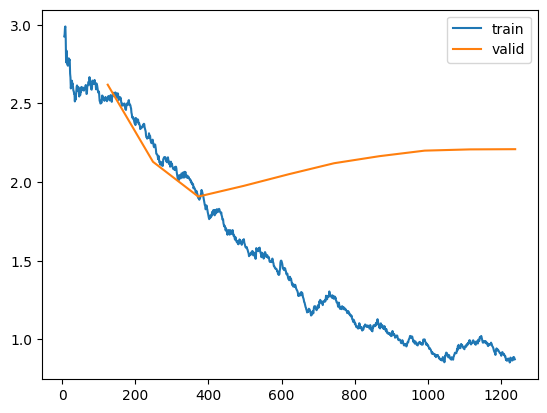

In [21]:
learn.recorder.plot_loss()

In [40]:
# We take epoch 6 as the validation accuracy and test accuracy are close.